In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import mne
from mne.datasets import sample
from mne import make_fixed_length_epochs
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

In [46]:
dir = 'ds004504'
num_sub = 'sub-001/eeg/sub-001_task-eyesclosed_eeg.set'
data_path = f'{dir}/{num_sub}'

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Events: []
Event ID: {}
[[-4.02340650e-20  2.50057893e-06  4.94455771e-06 ... -6.35194685e-06
  -5.49606813e-06 -4.96876402e-06]
 [-4.40457133e-20  1.91964935e-06  3.79083192e-06 ... -1.42753586e-05
  -1.34247044e-05 -1.27619283e-05]
 [-1.94817578e-20 -3.36175338e-07 -6.63354502e-07 ... -2.23333856e-05
  -2.16438405e-05 -2.11325322e-05]
 ...
 [-2.79785570e-20  1.41924481e-06  2.81093372e-06 ... -2.48235602e-05
  -2.44704269e-05 -2.42376813e-05]
 [-1.05879118e-21  1.62929932e-06  3.22045409e-06 ... -2.93726323e-05
  -2.89117207e-05 -2.85292476e-05]
 [-2.60462631e-20  1.57288613e-06  3.10210458e-06 ... -3.46175139e-05
  -3.45175855e-05 -3.44032937e-05]]


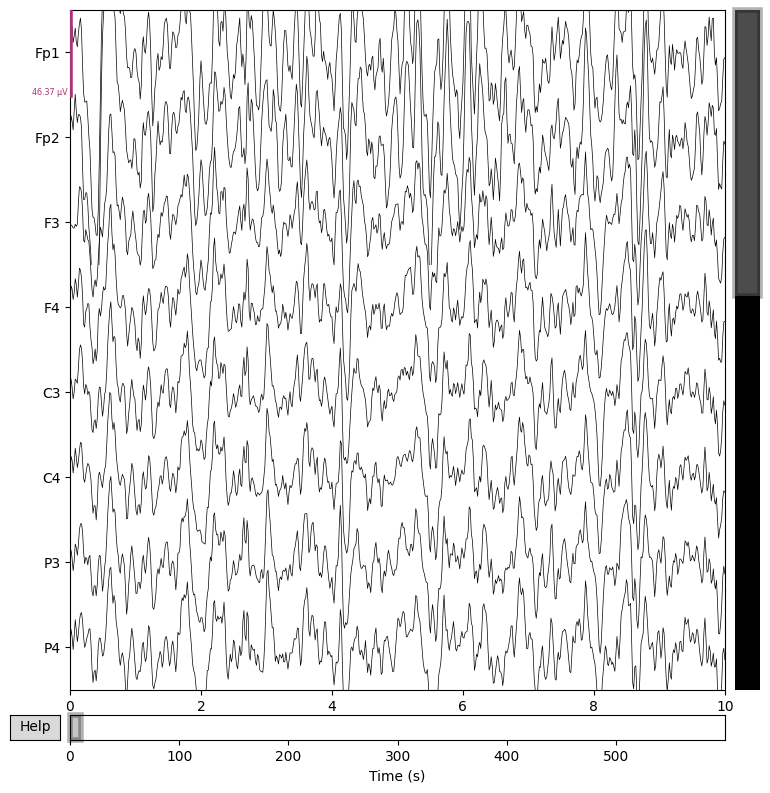

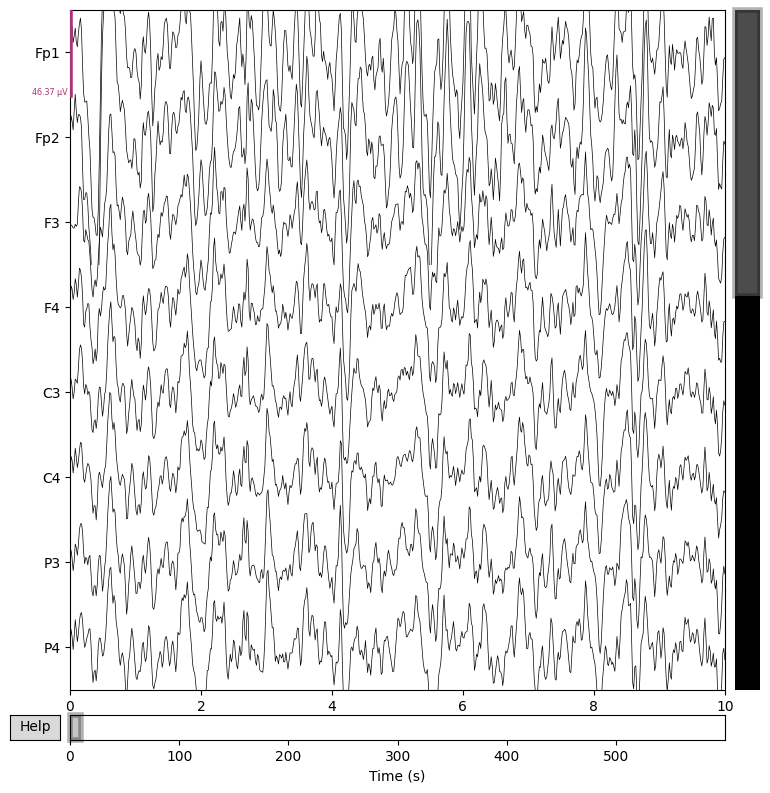

In [58]:
raw = mne.io.read_raw_eeglab(data_path, preload=True)
raw = raw.filter(2, 20)
annotations = raw.annotations


events, event_id = mne.events_from_annotations(raw)
#events = mne.find_events(raw, "STI 014")
print("Events:", events)
print("Event ID:", event_id)
data, times = raw[:]

n_samples = int(raw.info['sfreq'] * 2)  # 5 seconds of data
print(data[:, :n_samples])

raw.plot(n_channels=8, scalings='auto', title='Raw EEG Data', show=True)


Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 299 events and 1000 original time points ...
0 bad epochs dropped


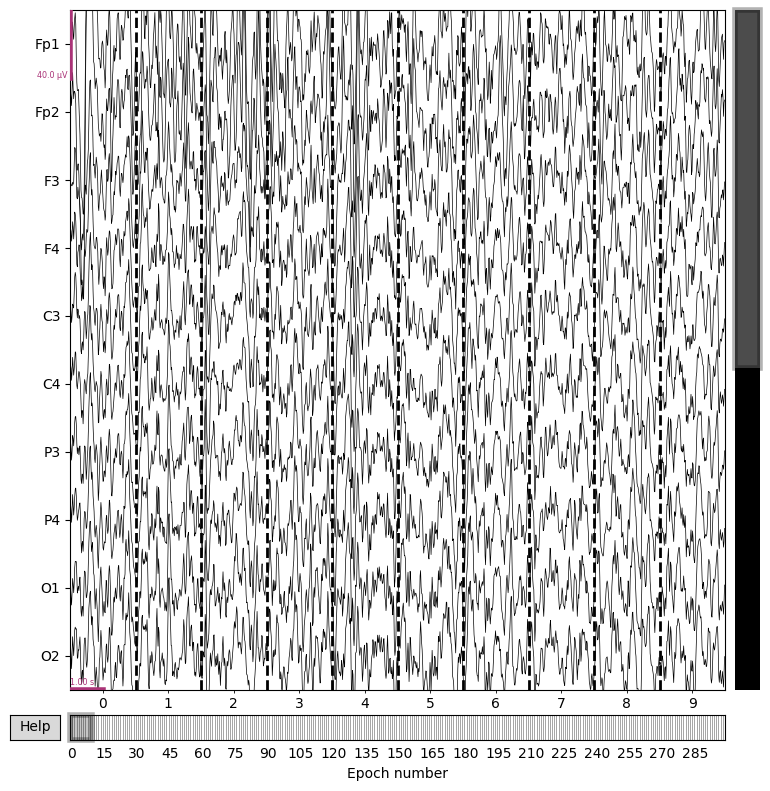

Shape of X: (299, 19, 1000)


/var/folders/cr/xdpvycqd5m5gw89n5v0tx1x80000gn/T/ipykernel_44204/3207895805.py:15: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


In [59]:
#Epoch Creation 

epoch_length = 2
sfreq = raw.info['sfreq']
n_samples = int(epoch_length * sfreq)
channel_names = [
    'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
]
channel_types = ['eeg'] * len(channel_names)
raw.rename_channels({old_name: new_name for old_name, new_name in zip(raw.ch_names, channel_names)})
epochs = make_fixed_length_epochs(raw, duration=epoch_length, preload=True, overlap=0)
epochs.plot(n_epochs=10, n_channels=10, title='First 10 epochs')
n_epochs = len(epochs)
X = epochs.get_data()
print(f'Shape of X: {X.shape}')
y = np.array([i % 2 for i in range(n_epochs)])


In [ ]:
clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver="liblinear"), 
)
del raw


In [ ]:
scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=None)
score = np.mean(scores, axis=0)
print(f"Spatio-temporal: {100 * score:0.1f}%")

In [ ]:
csp = CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(csp, LinearModel(LogisticRegression(solver="liblinear")))
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=None)
print(f"CSP: {100 * scores.mean():0.1f}%")

Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 19 dim * 3.6e+10  max singular value)
    Estimated rank (data): 19
    data: rank 19 computed from 19 data channels with 0 projectors
Reducing data rank from 19 -> 19
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 19 dim * 3.6e+10  max singular value)
    Estimated rank (data): 19
    data: rank 19 computed from 19 data channels with 0 projectors
Reducing data rank from 19 -> 19
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 19 dim * 3.6e+10  max singular value)
    Estimated rank (data): 19
    data: rank 19 computed from 19 data channels with 0 projectors
Reducing data rank from 19 -> 19
Estimating class=0 covariance using EMP

Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 19 dim * 4e+10  max singular value)
    Estimated rank (data): 19
    data: rank 19 computed from 19 data channels with 0 projectors
Reducing data rank from 19 -> 19
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


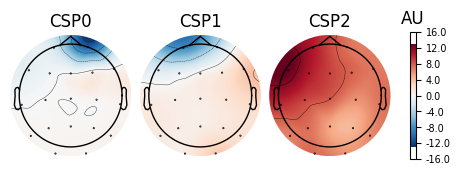

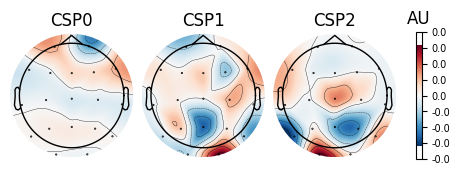

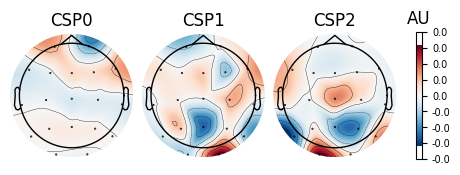

In [ ]:
csp.fit(X, y)
csp.plot_patterns(epochs.info)
csp.plot_filters(epochs.info, scalings=1e-9)

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)

scores = np.mean(scores, axis=0)

fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label="score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlabel("Times")
ax.set_ylabel("AUC") 
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

  0%|          | Fitting SlidingEstimator : 0/1000 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1000 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1000 [00:00<?,       ?it/s]

Text(0.5, 1.0, 'Sensor space decoding')

  0%|          | Fitting SlidingEstimator : 0/1000 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


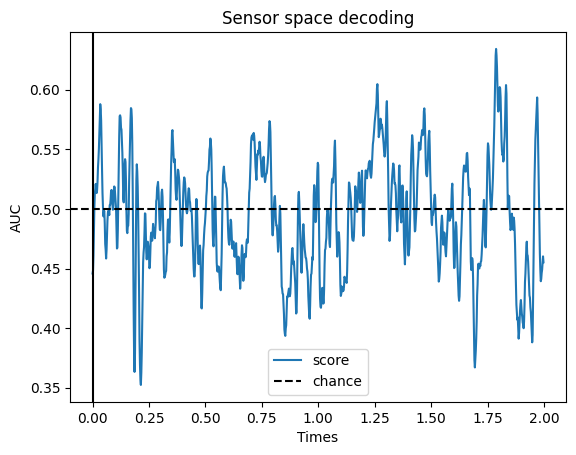

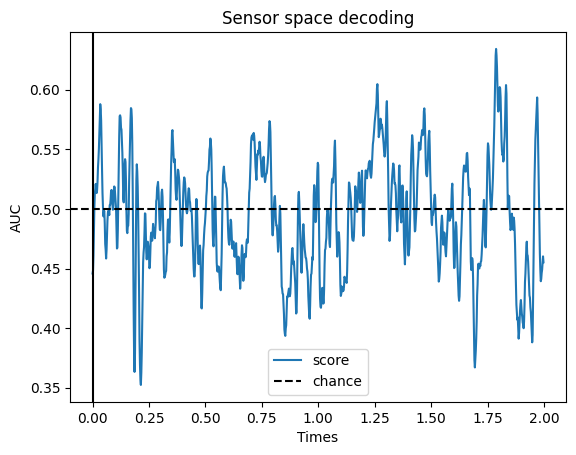

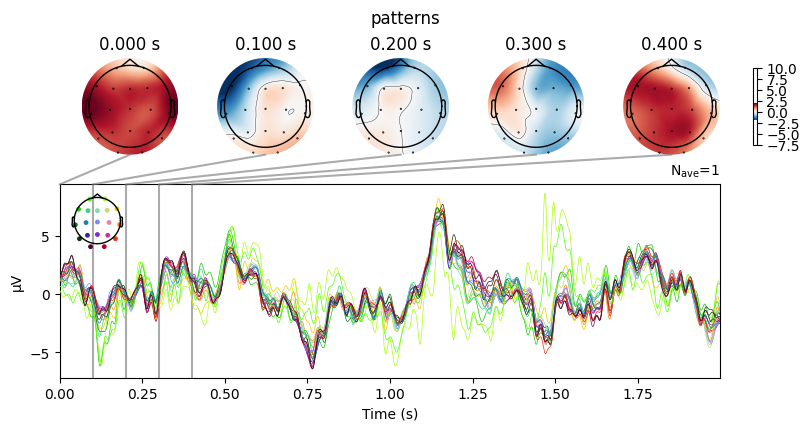

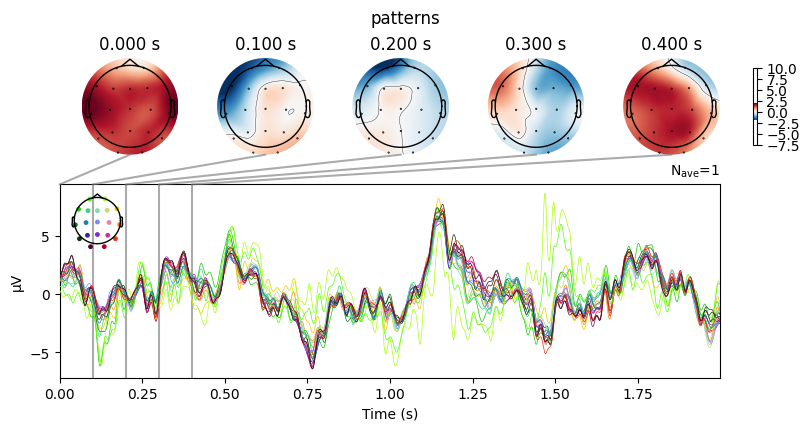

In [ ]:
clf = make_pipeline(
    StandardScaler(), LinearModel(LogisticRegression(solver="liblinear"))
)
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, "patterns_", inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s"))
evoked_time_gen.plot_joint(
    times=np.arange(0.0, 0.500, 0.100), title="patterns", **joint_kwargs
)